# Argo one filter scale

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

### Load and plot data

In [2]:
import filt_funcs as ff
import my_stats

In [3]:
#glider data
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
gselect=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))

#argo box
box=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
aselect=ff.get_ds_interp(box,0,2000,4)

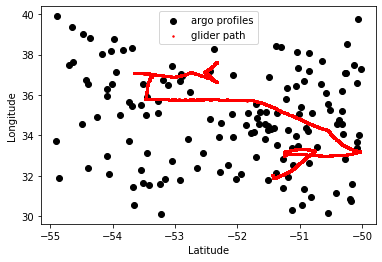

In [4]:
plt.scatter(aselect.LATITUDE,aselect.LONGITUDE,color='black',label='argo profiles')
plt.scatter(gselect.latitude,gselect.longitude,color='r',s=2,label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

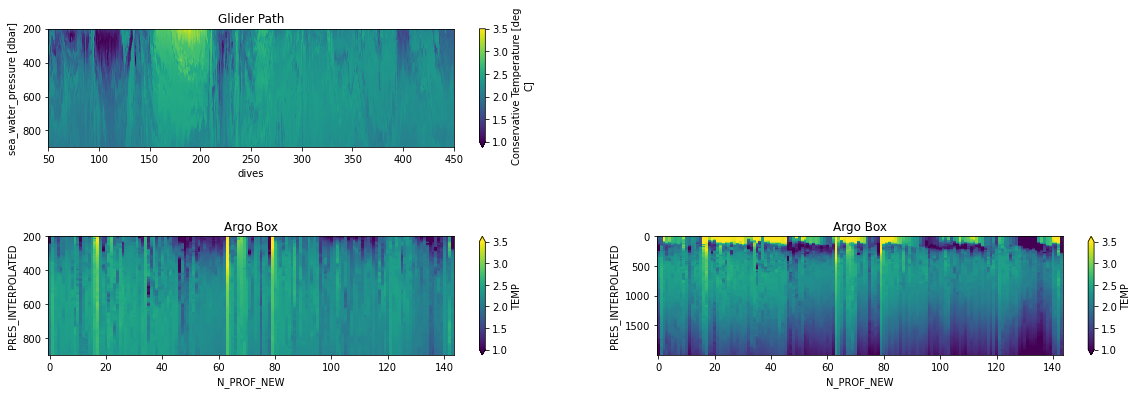

In [5]:
plt.figure(figsize=(20,6))

plt.subplot(2,2,1)
gselect.CT.plot(x='dives',y='ctd_pressure',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Glider Path')

plt.subplot(2,2,3)
aselect.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.ylim(200,900)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplot(2,2,4)
aselect.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplots_adjust(hspace=0.75)

## MKE/EKE method from Steinberg paper

These eqations are for energy at one spatial scale, where the eddy kinetic energy at scales smaller than the filter scale (EKE) and mean kinetic energy at scales larger than the filter scale (MKE) are:

$$
MKE = <u>^2
$$
$$
EKE = <u^2> - <u>^2
$$

(based on this paper: [Steinberg](https://journals.ametsoc.org/view/journals/phoc/52/8/JPO-D-21-0269.1.xml))

In [6]:
aselect_filt = ff.get_filt_multi(aselect,10,500,50,bound=True)

In [7]:
aselect_filt_l=aselect_filt.sel(FILT_SCALE=100)

MKE=aselect_filt_l**2

In [21]:
u2 = aselect[['TEMP','PSAL']]**2
u2_filt = ff.get_filt_single(u2,100)

EKE = u2_filt - MKE

Text(0.5, 1.0, 'EKE')

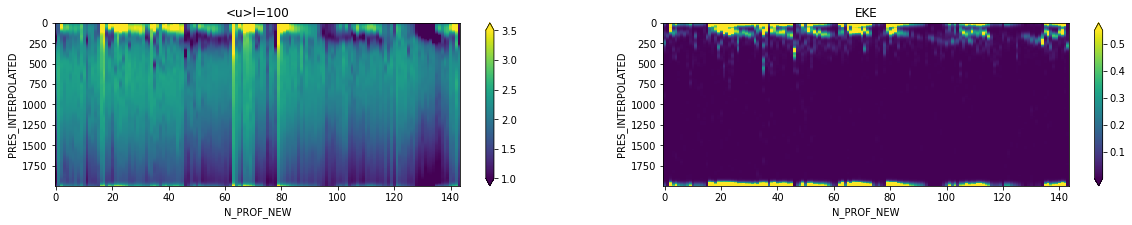

In [26]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
aselect_filt_l.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('<u>l=100')

plt.subplot(1,2,2)
EKE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()
plt.title('EKE')

Text(0.5, 1.0, 'Mean EKE')

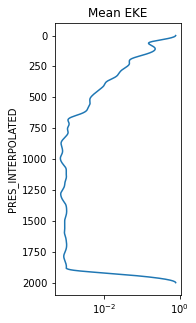

In [43]:
plt.figure(figsize=(5,5))

plt.subplot(1,2,1)
EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('Mean EKE')

## Load Data Boxes

In [16]:
#Same boxes and naming conventions from AGU_poster notebook

#North Pacific
np_ds=xr.open_dataset("202206_lon:(-155,-145)_lat:(30,35).nc")
np = ff.get_ds_interp(np_ds,0,2000,4)

#North Atlantic
na_ds=xr.open_dataset("202206_lon:(-55,-45)_lat:(40,45).nc")
na = ff.get_ds_interp(na_ds,0,2000,4)

#Souterh Ocean
so_ds=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
so = ff.get_ds_interp(so_ds,0,2000,4)

#Indian Ocean
io_ds=xr.open_dataset("202206_lon:(90,100)_lat:(-15,-10).nc")
io = ff.get_ds_interp(io_ds,0,2000,4)

In [17]:
np_filt = ff.get_filt_multi(np,10,500,50,bound=True)
na_filt = ff.get_filt_multi(na,10,500,50,bound=True)
so_filt = ff.get_filt_multi(so,10,500,50,bound=True)
io_filt = ff.get_filt_multi(io,10,500,50,bound=True)

In [21]:
np_filt_100 = np_filt.sel(FILT_SCALE=100.)
na_filt_100 = na_filt.sel(FILT_SCALE=100.)
so_filt_100 = so_filt.sel(FILT_SCALE=100.)
io_filt_100 = io_filt.sel(FILT_SCALE=100.)

In [29]:
np_MKE = np_filt_100**2
na_MKE = na_filt_100**2
so_MKE = so_filt_100**2
io_MKE = io_filt_100**2

In [26]:
np_TEMP2 = np[['TEMP']]**2
na_TEMP2 = na[['TEMP']]**2
so_TEMP2 = so[['TEMP']]**2
io_TEMP2 = io[['TEMP']]**2

In [28]:
np_TEMP2_filt = ff.get_filt_single(np_TEMP2,100)
na_TEMP2_filt = ff.get_filt_single(na_TEMP2,100)
so_TEMP2_filt = ff.get_filt_single(so_TEMP2,100)
io_TEMP2_filt = ff.get_filt_single(io_TEMP2,100)

In [31]:
np_EKE = np_TEMP2_filt - np_MKE
na_EKE = na_TEMP2_filt - na_MKE
so_EKE = so_TEMP2_filt - so_MKE
io_EKE = io_TEMP2_filt - io_MKE

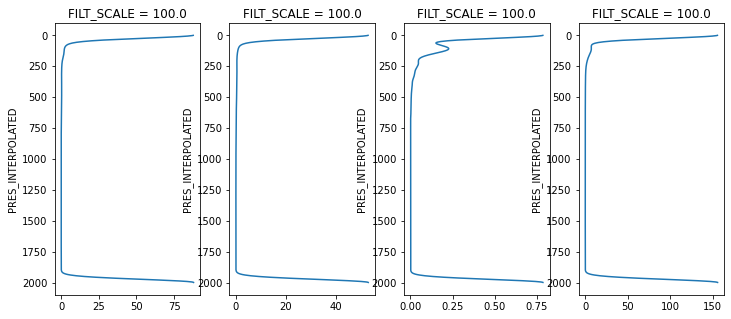

In [37]:
plt.figure(figsize=(12,5))

plt.subplot(1,4,1)
np_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

plt.subplot(1,4,2)
na_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

plt.subplot(1,4,3)
so_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

plt.subplot(1,4,4)
io_EKE.mean('N_PROF').plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

In [3]:
#New boxes to look at around the Southern Ocean

so1_ds = xr.open_dataset("202206_lon:(120,130)_lat:(-60,-55).nc")
so1 = ff.get_ds_interp(so1_ds,0,2000,4)

so2_ds = xr.open_dataset("202206_lon:(-180,-170)_lat:(-60,-55).nc")
so2 = ff.get_ds_interp(so2_ds,0,2000,4)

so3_ds = xr.open_dataset("202206_lon:(-120,-110)_lat:(-60,-55).nc")
so3 = ff.get_ds_interp(so3_ds,0,2000,4)

so4_ds = xr.open_dataset("202206_lon:(-60,-50)_lat:(-60,-55).nc")
so4 = ff.get_ds_interp(so4_ds,0,2000,4)

so5_ds = xr.open_dataset("202206_lon:(0,10)_lat:(-60,-55).nc")
so5 = ff.get_ds_interp(so5_ds,0,2000,4)

so6_ds = xr.open_dataset("202206_lon:(60,70)_lat:(-60,-55).nc")
so6 = ff.get_ds_interp(so6_ds,0,2000,4)

In [11]:
so1_filt = ff.get_filt_multi(so1,10,500,50,bound=True)
so2_filt = ff.get_filt_multi(so2,10,500,50,bound=True)
so3_filt = ff.get_filt_multi(so3,10,500,50,bound=True)
so4_filt = ff.get_filt_multi(so4,10,500,50,bound=True)
so5_filt = ff.get_filt_multi(so5,10,500,50,bound=True)
so6_filt = ff.get_filt_multi(so6,10,500,50,bound=True)